In [1]:
import pandas as pd
import os

In [2]:
import seaborn as sns

In [3]:
from matplotlib import __version__

In [4]:
__version__

'3.4.3'

In [5]:
from neuralprophet import NeuralProphet

In [6]:
data_dir = "./data/"
dataset = './data/tuples/autovac/autovacon_ycsb_scale_50_worktime_3600_samplefreq_1_tsizeAnddeadtuple_pgconfig_delete_25_dead_tup_dtw.csv'

In [7]:
df = pd.read_csv(dataset)

In [8]:
df.head()

,ds,table_name,pg_stat_get_live_tuples,pg_stat_get_dead_tuples,pg_table_size,relid,schemaname,relname,seq_scan,seq_tup_read,...,n_mod_since_analyze,n_ins_since_vacuum,last_vacuum,last_autovacuum,last_analyze,last_autoanalyze,vacuum_count,autovacuum_count,analyze_count,autoanalyze_count
0,1.650448e+09,public.usertable,50000,0,58556416,16943,public,usertable,1,0,...,50000,50000,NaN,NaN,NaN,NaN,0,0,0,0
1,1.650448e+09,public.usertable,50000,0,58638336,16943,public,usertable,1,0,...,50000,50000,NaN,NaN,NaN,NaN,0,0,0,0
2,1.650448e+09,public.usertable,49963,398,59097088,16943,public,usertable,1,0,...,50530,50097,NaN,NaN,NaN,NaN,0,0,0,0
3,1.650448e+09,public.usertable,49923,894,59588608,16943,public,usertable,1,0,...,51207,50238,NaN,NaN,NaN,NaN,0,0,0,0
4,1.650448e+09,public.usertable,49894,1395,60112896,16943,public,usertable,1,0,...,51912,50396,NaN,NaN,NaN,NaN,0,0,0,0


In [9]:
df.table_name.unique()

array(['public.usertable'], dtype=object)

In [10]:
df.columns

Index(['ds', 'table_name', 'pg_stat_get_live_tuples',
       'pg_stat_get_dead_tuples', 'pg_table_size', 'relid', 'schemaname',
       'relname', 'seq_scan', 'seq_tup_read', 'idx_scan', 'idx_tup_fetch',
       'n_tup_ins', 'n_tup_upd', 'n_tup_del', 'n_tup_hot_upd', 'n_live_tup',
       'n_dead_tup', 'n_mod_since_analyze', 'n_ins_since_vacuum',
       'last_vacuum', 'last_autovacuum', 'last_analyze', 'last_autoanalyze',
       'vacuum_count', 'autovacuum_count', 'analyze_count',
       'autoanalyze_count'],
      dtype='object')

In [11]:
df['ds'] = df['ds']-df['ds'].min()
df['ds'] = pd.to_datetime(df['ds'], unit='s').round('s')
df['pg_table_size'] = df['pg_table_size']//(2<<10)

In [12]:
def plot_growth(df, col):
    return sns.lineplot(data=df, x='ds', y=col, hue='table_name')

<AxesSubplot:xlabel='ds', ylabel='n_dead_tup'>

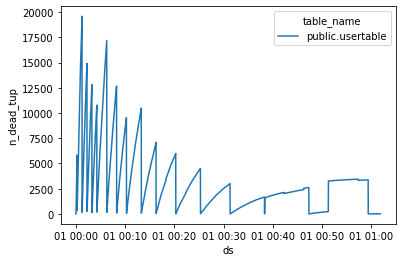

In [13]:
# g = sns.FacetGrid(df, row='table_name', sharey=False)
# g.map(sns.lineplot, "ds", "n_dead_tup")
sns.lineplot(data=df, x='ds', y='n_dead_tup', hue='table_name')

In [14]:
def make_predictions(df, col):
    fdf = pd.DataFrame({'ds': df.ds.round('s'), 'y': df[col] - df[col].min()})
    m = NeuralProphet()
    metrics = m.fit(fdf[:fdf.shape[0]//2], freq="s")
    return m, fdf

In [15]:
m, fdf = make_predictions(df, 'n_dead_tup')

INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 97.344% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 162


  0%|          | 0/132 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.96E+00, min: 3.67E-02


  0%|          | 0/132 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.41E-01, min: 3.67E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.55E-01
Epoch[162/162]: 100%|██████████| 162/162 [00:13<00:00, 11.71it/s, SmoothL1Loss=0.0305, MAE=2.24e+3, RMSE=2.95e+3, RegLoss=0]


INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 97.344% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 97.344% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s


<AxesSubplot:>

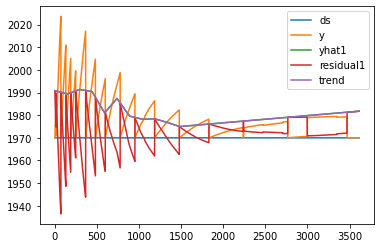

In [16]:
forecast = m.predict(fdf)
forecast.plot()

INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 97.344% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 162


  0%|          | 0/132 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.30E-01, min: 1.28E+01


  0%|          | 0/132 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.30E-01, min: 1.28E+01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.19E-01
Epoch[162/162]: 100%|██████████| 162/162 [00:13<00:00, 11.68it/s, SmoothL1Loss=6.92e-6, MAE=988, RMSE=1.21e+3, RegLoss=0]    
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 97.344% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 97.344% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s


<AxesSubplot:>

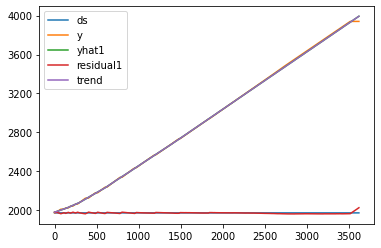

In [17]:
m, fdf = make_predictions(df, 'pg_table_size')
forecast = m.predict(fdf)
forecast.plot()

<AxesSubplot:xlabel='ds', ylabel='pg_table_size'>

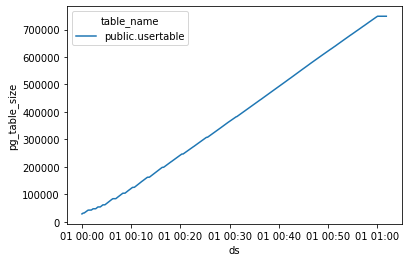

In [18]:
# g2 = sns.FacetGrid(df, row='table_name', sharey=False)
# g2.map(sns.lineplot, "ds", "pg_table_size")
# g2.fig.tight_layout(pad=2)
sns.lineplot(data=df, x='ds', y='pg_table_size', hue='table_name')

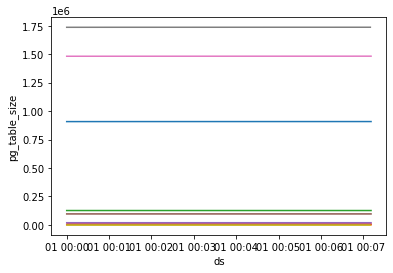

In [166]:
for tab in df.table_name.unique():
    p = sns.lineplot(data=df[df.table_name == tab], x='ds', y='pg_table_size')

In [124]:
oorder_df = df[df.table_name == 'public.oorder'].copy()

In [125]:
oorder_df.head()

,ds,table_name,relid,schemaname,relname,seq_scan,seq_tup_read,idx_scan,idx_tup_fetch,n_tup_ins,...,n_ins_since_vacuum,last_vacuum,last_autovacuum,last_analyze,last_autoanalyze,vacuum_count,autovacuum_count,analyze_count,autoanalyze_count,pg_table_size
5,1970-01-01 00:00:00,public.oorder,17314,public,oorder,3,0,30901892.0,30901892.0,3000000,...,190672,NaN,2022-04-19 20:43:49.993237+00:00,NaN,2022-04-19 20:43:50.713871+00:00,0,10,0,14,96540
14,1970-01-01 00:00:01,public.oorder,17314,public,oorder,3,0,30901892.0,30901892.0,3000000,...,190672,NaN,2022-04-19 20:43:49.993237+00:00,NaN,2022-04-19 20:43:50.713871+00:00,0,10,0,14,96540
23,1970-01-01 00:00:02,public.oorder,17314,public,oorder,3,0,30901892.0,30901892.0,3000000,...,190672,NaN,2022-04-19 20:43:49.993237+00:00,NaN,2022-04-19 20:43:50.713871+00:00,0,10,0,14,96540
32,1970-01-01 00:00:03,public.oorder,17314,public,oorder,3,0,30901892.0,30901892.0,3000000,...,190672,NaN,2022-04-19 20:43:49.993237+00:00,NaN,2022-04-19 20:43:50.713871+00:00,0,10,0,14,96540
41,1970-01-01 00:00:04,public.oorder,17314,public,oorder,3,0,30901892.0,30901892.0,3000000,...,190672,NaN,2022-04-19 20:43:49.993237+00:00,NaN,2022-04-19 20:43:50.713871+00:00,0,10,0,14,96540


In [147]:
def make_predictions(df):]
    fdf = pd.DataFrame({'ds': df.ds.round('s'), 'y': df.pg_table_size - df.pg_table_size.min()})
    m = NeuralProphet()
    metrics = m.fit(fdf[:fdf.shape[0]//2], freq="s")
    return m, fdf

INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.07% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 352


  0%|          | 0/112 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.88E-02, min: 4.18E+00


  0%|          | 0/112 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.93E+01, min: 5.04E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.47E-01
Epoch[352/352]: 100%|██████████| 352/352 [00:09<00:00, 38.71it/s, SmoothL1Loss=0.00115, MAE=0.753, RMSE=0.945, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.302% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.302% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s


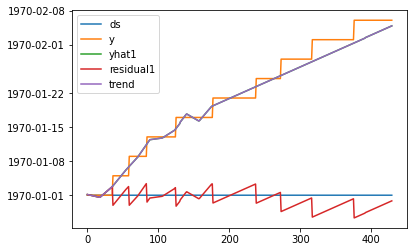

In [138]:
model, fdf = make_predictions(oorder_df)

In [140]:
df[df.table_name == 'public.customer'].copy()

,ds,table_name,relid,schemaname,relname,seq_scan,seq_tup_read,idx_scan,idx_tup_fetch,n_tup_ins,...,n_ins_since_vacuum,last_vacuum,last_autovacuum,last_analyze,last_autoanalyze,vacuum_count,autovacuum_count,analyze_count,autoanalyze_count,pg_table_size
0,1970-01-01 00:00:00,public.customer,17287,public,customer,2,0,6000000.0,97106539.0,3000000,...,360000,NaN,2022-04-19 20:41:54.438578+00:00,NaN,2022-04-19 20:44:48.352263+00:00,0,10,0,14,907804
9,1970-01-01 00:00:01,public.customer,17287,public,customer,2,0,6000000.0,97106539.0,3000000,...,360000,NaN,2022-04-19 20:41:54.438578+00:00,NaN,2022-04-19 20:44:48.352263+00:00,0,10,0,14,907816
18,1970-01-01 00:00:02,public.customer,17287,public,customer,2,0,6000000.0,97106539.0,3000000,...,360000,NaN,2022-04-19 20:41:54.438578+00:00,NaN,2022-04-19 20:44:48.352263+00:00,0,10,0,14,907832
27,1970-01-01 00:00:03,public.customer,17287,public,customer,2,0,6000000.0,97106539.0,3000000,...,360000,NaN,2022-04-19 20:41:54.438578+00:00,NaN,2022-04-19 20:44:48.352263+00:00,0,10,0,14,907832
36,1970-01-01 00:00:04,public.customer,17287,public,customer,2,0,6000000.0,97106539.0,3000000,...,360000,NaN,2022-04-19 20:41:54.438578+00:00,NaN,2022-04-19 20:44:48.352263+00:00,0,10,0,14,907832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,1970-01-01 00:07:07,public.customer,17287,public,customer,2,0,6000000.0,97106539.0,3000000,...,360000,NaN,2022-04-19 20:41:54.438578+00:00,NaN,2022-04-19 20:44:48.352263+00:00,0,10,0,14,908228
3834,1970-01-01 00:07:08,public.customer,17287,public,customer,2,0,6000000.0,97106539.0,3000000,...,360000,NaN,2022-04-19 20:41:54.438578+00:00,NaN,2022-04-19 20:44:48.352263+00:00,0,10,0,14,908228
3843,1970-01-01 00:07:09,public.customer,17287,public,customer,2,0,6000000.0,97106539.0,3000000,...,360000,NaN,2022-04-19 20:41:54.438578+00:00,NaN,2022-04-19 20:44:48.352263+00:00,0,10,0,14,908228
3852,1970-01-01 00:07:10,public.customer,17287,public,customer,2,0,6000000.0,97106539.0,3000000,...,360000,NaN,2022-04-19 20:41:54.438578+00:00,NaN,2022-04-19 20:44:48.352263+00:00,0,10,0,14,908228


<AxesSubplot:xlabel='ds', ylabel='pg_table_size'>

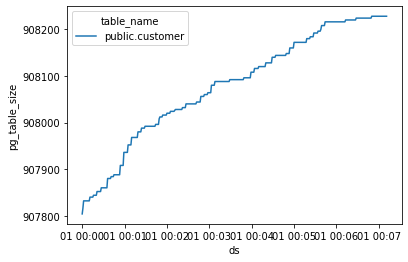

In [142]:
plot_growth(df[df.table_name == 'public.customer'].copy(), 'pg_table_size')

INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.07% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 352


  0%|          | 0/112 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.75E-01, min: 1.28E+01


  0%|          | 0/112 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.75E-01, min: 1.86E+01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.45E-01
Epoch[352/352]: 100%|██████████| 352/352 [00:08<00:00, 39.59it/s, SmoothL1Loss=0.000133, MAE=3.64, RMSE=4.57, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.302% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.302% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s


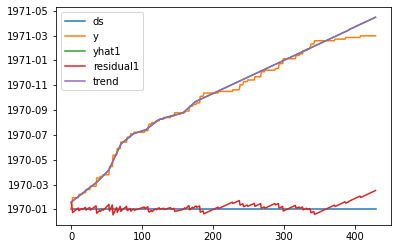

In [144]:
_ = make_predictions(df[df.table_name == 'public.customer'].copy())

INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.302% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.302% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s


<AxesSubplot:>

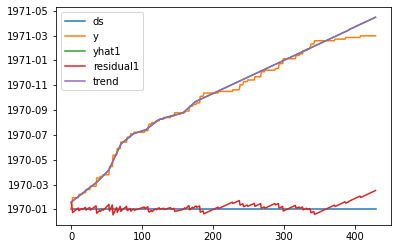

In [146]:
_[0].predict(_[1]).plot()

In [148]:
models = {}

In [151]:
for table in df.table_name.unique():
    print(table)
    if table in ['public.item', 'public.warehouse']:
        continue
    model, data = make_predictions(df[df.table_name == table].copy())
    models[table] = {'model': model, 'data': data}

INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.07% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 352


  0%|          | 0/112 [00:00<?, ?it/s]

public.customer


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.30E-02, min: 6.08E+00


  0%|          | 0/112 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.88E-02, min: 5.04E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.30E-02
Epoch[352/352]: 100%|██████████| 352/352 [00:09<00:00, 38.99it/s, SmoothL1Loss=0.000134, MAE=3.63, RMSE=4.54, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.07% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to

  0%|          | 0/112 [00:00<?, ?it/s]

public.district


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.30E-02, min: 1.75E-01


  0%|          | 0/112 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.30E-02, min: 1.75E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.83E-02
Epoch[352/352]: 100%|██████████| 352/352 [00:09<00:00, 36.28it/s, SmoothL1Loss=0.00195, MAE=0.0427, RMSE=0.129, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.07% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True 

  0%|          | 0/112 [00:00<?, ?it/s]

public.history


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.88E-02, min: 1.65E+00


  0%|          | 0/112 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.88E-02, min: 1.65E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.80E-02
Epoch[352/352]: 100%|██████████| 352/352 [00:08<00:00, 40.62it/s, SmoothL1Loss=0.000621, MAE=0.789, RMSE=0.973, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.07% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True 

  0%|          | 0/112 [00:00<?, ?it/s]

public.item
public.new_order


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.74E-02, min: 1.65E+00


  0%|          | 0/112 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.74E-02, min: 2.88E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.08E-02
Epoch[352/352]: 100%|██████████| 352/352 [00:08<00:00, 40.77it/s, SmoothL1Loss=0.00136, MAE=0.587, RMSE=0.818, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.07% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True t

  0%|          | 0/112 [00:00<?, ?it/s]

public.oorder


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.37E-01, min: 8.30E-02


  0%|          | 0/112 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.37E-01, min: 8.30E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.07E-01
Epoch[352/352]: 100%|██████████| 352/352 [00:08<00:00, 40.93it/s, SmoothL1Loss=0.00115, MAE=0.753, RMSE=0.942, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.07% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True t

  0%|          | 0/112 [00:00<?, ?it/s]

public.order_line


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.45E-01, min: 2.88E+00


  0%|          | 0/112 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.45E-01, min: 2.88E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.28E-01
Epoch[352/352]: 100%|██████████| 352/352 [00:08<00:00, 40.85it/s, SmoothL1Loss=0.00016, MAE=5.1, RMSE=6.6, RegLoss=0]   
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.065% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True t

  0%|          | 0/112 [00:00<?, ?it/s]

public.stock


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.88E-02, min: 1.75E-01


  0%|          | 0/112 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.88E-02, min: 4.18E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.80E-02
Epoch[353/353]: 100%|██████████| 353/353 [00:08<00:00, 41.15it/s, SmoothL1Loss=0.000142, MAE=4.75, RMSE=6.12, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.065% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
ERROR - (NP.df_utils.auto_normalization_setting) - encountered variable with one unique value


public.warehouse


ValueError: 

INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.302% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.302% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.302% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.302% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s


public.customer
public.district


INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.302% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.302% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.302% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.302% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.302% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.302%

public.history
public.new_order
public.oorder


INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.302% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.302% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.301% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 99.301% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s


public.order_line
public.stock


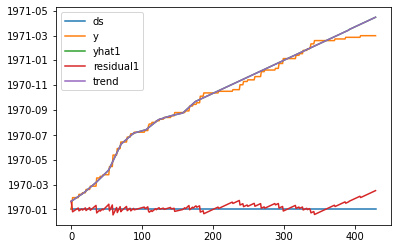

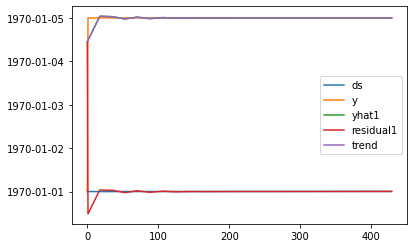

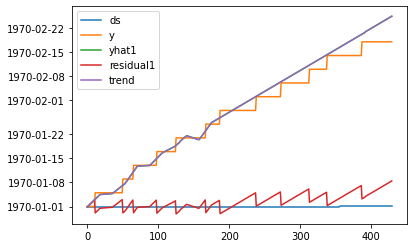

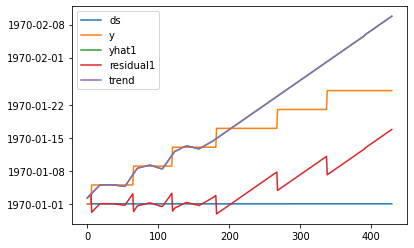

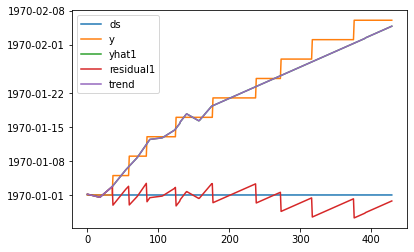

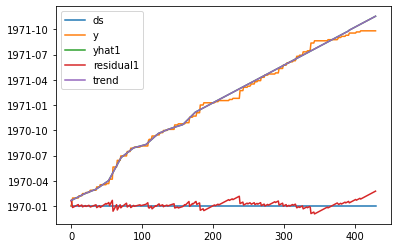

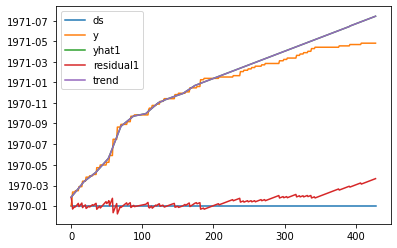

In [154]:
for table, mod in models.items():
    print(table)
    forecast = mod['model'].predict(mod['data'])
    plt = forecast.plot()
#     plt.show()